# Collinear features

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split

In [103]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','longitude','latitude', 'price']
df = df[features].copy()

# Clip to remove outliers
df = df[(df['latitude']>40.55) & (df['latitude']<40.94) &
        (df['longitude']>-74.1) & (df['longitude']<-73.67)]
df = df[(df.price>1_000) & (df.price<10_000)]

df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train[['bedrooms','bathrooms','latitude','longitude']]
y_train = df_train['price']
X_test = df_test[['bedrooms','bathrooms','latitude','longitude']]
y_test = df_test['price']

rf = RandomForestRegressor(oob_score=True, n_estimators=100, n_jobs=-1)

## Drop column

CPU times: user 26.8 s, sys: 866 ms, total: 27.7 s
Wall time: 6.08 s


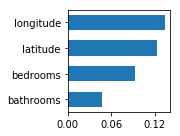

In [104]:
%time I = dropcol_importances(rf, X_train, y_train)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_dropcol.svg')

CPU times: user 45.6 s, sys: 1.17 s, total: 46.8 s
Wall time: 9.31 s


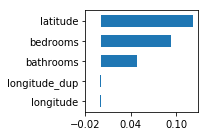

In [105]:
X_train_drop = X_train.copy()
X_train_drop['longitude_dup'] = X_train_drop.longitude
%time I = dropcol_importances(rf, X_train_drop, y_train)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_dropcol_longitude_dup.svg')

CPU times: user 34.7 s, sys: 1.03 s, total: 35.7 s
Wall time: 7.45 s


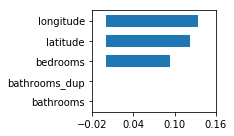

In [106]:
X_train_drop = X_train.copy()
X_train_drop['bathrooms_dup'] = X_train_drop.bathrooms
%time I = dropcol_importances(rf, X_train_drop, y_train)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_dropcol_bathrooms_dup.svg')

## Validation set

In [108]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
print(rf.oob_score_)

0.8618343643601613


(9660, 4)
CPU times: user 1.14 s, sys: 34 ms, total: 1.18 s
Wall time: 529 ms


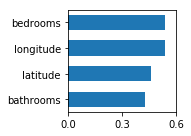

In [109]:
print(X_test.shape)
%time I = importances(rf, X_test, y_test, n_samples=-1)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_permute.svg')

CPU times: user 4.53 s, sys: 55.5 ms, total: 4.59 s
Wall time: 953 ms


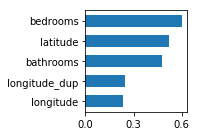

In [111]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
X_train_val = X_train.copy()
X_train_val['longitude_dup'] = X_train_val.longitude
rf.fit(X_train_val, y_train)
%time I = importances(rf, X_train_val, y_train, n_samples=-1)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_permute_longitude_dup.svg')

CPU times: user 6.28 s, sys: 70.6 ms, total: 6.35 s
Wall time: 1.26 s


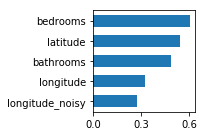

In [138]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
X_train_val = X_train.copy()
longitude_mean = np.mean(X_train_val.longitude)
longitude_range = max(X_train_val.longitude) - min(X_train_val.longitude)
# Range is .3938 so add uniform noise in range 0..c
c = .0005
noise = np.random.random(len(X_train_val))*c

X_train_val['longitude_noisy'] = X_train_val.longitude + noise
rf.fit(X_train_val, y_train)
%time I = importances(rf, X_train_val, y_train, n_samples=-1)
plot_importances(I, scalefig=(1,.5), save='../article/images/collinear_permute_longitude_dup.svg')

## Cross validation

CPU times: user 1min 22s, sys: 3.35 s, total: 1min 26s
Wall time: 15.4 s


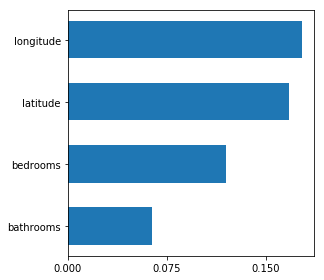

In [94]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
%time I = cv_importances(rf, X_train, y_train)
plot_importances(I)

## Eli5

CPU times: user 4.58 s, sys: 149 ms, total: 4.73 s
Wall time: 2.24 s


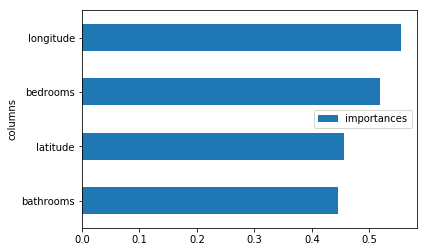

In [96]:
from eli5.sklearn import PermutationImportance
import eli5

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

%time perm = PermutationImportance(rf).fit(X_test, y_test)
I = pd.DataFrame(data={"columns":X_test.columns, "importances":perm.feature_importances_})
I = I.set_index("columns")
I = I.sort_values('importances', ascending=True)
I.plot.barh()